In [1]:
!pip install kaggle

In [2]:
!kaggle competitions download -c tpsbsdaa2122

tpsbsdaa2122.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import kaggle 
import pandas as pd
import seaborn as sns
import numpy as np
import re
from sklearn.tree import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

### **Tratamento dos dados**

In [4]:
training_file = 'Datasets/training_data.csv'
test_file = 'Datasets/test_data.csv'

def tratamentoDados(filename):
    df = pd.read_csv(filename,encoding = "ISO-8859-1")
    df = df.drop(['city_name','AVERAGE_PRECIPITATION','AVERAGE_RAIN'],axis=1)
    df['LUMINOSITY'].replace({"DARK": 0, "LOW_LIGHT": 1, "LIGHT": 2}, inplace=True)
    df['AVERAGE_CLOUDINESS'].replace({"céu limpo": 0, "céu claro": 1, "nuvens dispersas": 2,"nuvens quebrados": 3,"nuvens quebradas": 3,"algumas nuvens": 4,"céu pouco nublado":5,'tempo nublado': 6,'nublado': 6}, inplace=True)
    df['AVERAGE_CLOUDINESS']=df['AVERAGE_CLOUDINESS'].fillna(method='bfill')
    df['AVERAGE_CLOUDINESS']=df['AVERAGE_CLOUDINESS'].fillna(method='ffill')
    df['record_date']=df['record_date'].str.slice(11,-6).astype(int)
    return df

def labelToNumeric(df):
    df['AVERAGE_SPEED_DIFF'].replace({"None": 0, "Low": 1, "Medium": 2, "High": 3, "Very_High": 4}, inplace=True)
    

In [5]:
df = pd.read_csv(training_file,encoding = "ISO-8859-1")

In [6]:
df.head()

,city_name,record_date,AVERAGE_SPEED_DIFF,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS,AVERAGE_PRECIPITATION,AVERAGE_RAIN
0,Porto,2019-08-29 07:00:00,Medium,41.5,11.5,71.4,LIGHT,15.0,1019.0,100.0,3.0,NaN,0.0,NaN
1,Porto,2018-08-10 14:00:00,High,41.7,48.3,87.4,LIGHT,21.0,1021.0,53.0,5.0,céu claro,0.0,NaN
2,Porto,2019-09-01 16:00:00,High,38.6,38.4,85.2,LIGHT,26.0,1014.0,61.0,4.0,NaN,0.0,NaN
3,Porto,2019-02-26 11:00:00,High,37.4,61.0,94.1,LIGHT,18.0,1025.0,48.0,4.0,céu claro,0.0,NaN
4,Porto,2019-06-06 12:00:00,Medium,41.6,50.4,77.0,LIGHT,15.0,1008.0,82.0,10.0,NaN,0.0,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city_name                6812 non-null   object 
 1   record_date              6812 non-null   object 
 2   AVERAGE_SPEED_DIFF       6812 non-null   object 
 3   AVERAGE_FREE_FLOW_SPEED  6812 non-null   float64
 4   AVERAGE_TIME_DIFF        6812 non-null   float64
 5   AVERAGE_FREE_FLOW_TIME   6812 non-null   float64
 6   LUMINOSITY               6812 non-null   object 
 7   AVERAGE_TEMPERATURE      6812 non-null   float64
 8   AVERAGE_ATMOSP_PRESSURE  6812 non-null   float64
 9   AVERAGE_HUMIDITY         6812 non-null   float64
 10  AVERAGE_WIND_SPEED       6812 non-null   float64
 11  AVERAGE_CLOUDINESS       4130 non-null   object 
 12  AVERAGE_PRECIPITATION    6812 non-null   float64
 13  AVERAGE_RAIN             563 non-null    object 
dtypes: float64(8), object(6)

In [8]:
df.describe()

,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_PRECIPITATION
count,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.0
mean,40.661010,25.637111,81.143952,16.193482,1017.388139,80.084190,3.058573,0.0
std,4.119023,33.510507,8.294401,5.163492,5.751061,18.238863,2.138421,0.0
min,30.500000,0.000000,46.400000,0.000000,985.000000,14.000000,0.000000,0.0
25%,37.600000,2.275000,75.400000,13.000000,1015.000000,69.750000,1.000000,0.0
50%,40.700000,12.200000,82.400000,16.000000,1017.000000,83.000000,3.000000,0.0
75%,43.500000,36.200000,87.400000,19.000000,1021.000000,93.000000,4.000000,0.0
max,55.900000,296.500000,112.000000,35.000000,1033.000000,100.000000,14.000000,0.0


In [9]:
print(df.isna().sum())

city_name                     0
record_date                   0
AVERAGE_SPEED_DIFF            0
AVERAGE_FREE_FLOW_SPEED       0
AVERAGE_TIME_DIFF             0
AVERAGE_FREE_FLOW_TIME        0
LUMINOSITY                    0
AVERAGE_TEMPERATURE           0
AVERAGE_ATMOSP_PRESSURE       0
AVERAGE_HUMIDITY              0
AVERAGE_WIND_SPEED            0
AVERAGE_CLOUDINESS         2682
AVERAGE_PRECIPITATION         0
AVERAGE_RAIN               6249
dtype: int64


In [10]:
print(df.LUMINOSITY.unique())
print(df.AVERAGE_CLOUDINESS.unique())
print(df.city_name.unique())
print(df.AVERAGE_RAIN.unique())
print(df.AVERAGE_PRECIPITATION.unique())
print(df.record_date.unique())

['LIGHT' 'LOW_LIGHT' 'DARK']
[nan 'céu claro' 'nuvens dispersas' 'céu pouco nublado' 'céu limpo'
 'algumas nuvens' 'nuvens quebrados' 'tempo nublado' 'nuvens quebradas'
 'nublado']
['Porto']
[nan 'chuva fraca' 'chuva' 'chuva leve' 'chuvisco fraco' 'chuva moderada'
 'trovoada com chuva leve' 'aguaceiros' 'aguaceiros fracos'
 'chuva de intensidade pesada' 'trovoada com chuva'
 'chuva de intensidade pesado' 'chuva forte' 'chuvisco e chuva fraca']
[0.]
['2019-08-29 07:00:00' '2018-08-10 14:00:00' '2019-09-01 16:00:00' ...
 '2018-10-02 04:00:00' '2019-01-30 01:00:00' '2019-06-15 21:00:00']


In [11]:
for c in df.columns:
    valores_unicos = df[c].unique()
    if len(valores_unicos) < 10:
        print(f'{c} : {valores_unicos}')

city_name : ['Porto']
AVERAGE_SPEED_DIFF : ['Medium' 'High' 'None' 'Low' 'Very_High']
LUMINOSITY : ['LIGHT' 'LOW_LIGHT' 'DARK']
AVERAGE_PRECIPITATION : [0.]


#### **Eliminar colunas**

In [12]:
# city_name e AVERAGE_PRECIPITATION só tem uma entrada por isso são inuteis
# AVERAGE_RAIN é quase tudo valores nulos 

df = df.drop(['city_name','AVERAGE_PRECIPITATION','AVERAGE_RAIN'],axis=1)

In [13]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   record_date              6812 non-null   object 
 1   AVERAGE_SPEED_DIFF       6812 non-null   object 
 2   AVERAGE_FREE_FLOW_SPEED  6812 non-null   float64
 3   AVERAGE_TIME_DIFF        6812 non-null   float64
 4   AVERAGE_FREE_FLOW_TIME   6812 non-null   float64
 5   LUMINOSITY               6812 non-null   object 
 6   AVERAGE_TEMPERATURE      6812 non-null   float64
 7   AVERAGE_ATMOSP_PRESSURE  6812 non-null   float64
 8   AVERAGE_HUMIDITY         6812 non-null   float64
 9   AVERAGE_WIND_SPEED       6812 non-null   float64
 10  AVERAGE_CLOUDINESS       4130 non-null   object 
dtypes: float64(7), object(4)
memory usage: 585.5+ KB


In [14]:
# Transformar 'LUMINOSITY' em inteiros
df['LUMINOSITY'].replace({"DARK": 0, "LOW_LIGHT": 1, "LIGHT": 2}, inplace=True)

In [15]:
# Quantificar AVERAGE_CLOUDINESS
df['AVERAGE_CLOUDINESS'].replace({"céu limpo": 0, "céu claro": 1, "nuvens dispersas": 2,"nuvens quebrados": 3,"nuvens quebradas": 3,"algumas nuvens": 4,"céu pouco nublado":5,'tempo nublado': 6,'nublado': 6}, inplace=True)

In [16]:
#Fill null AVERAGE_CLOUDINESS

df['AVERAGE_CLOUDINESS']=df['AVERAGE_CLOUDINESS'].fillna(method='bfill')
df['AVERAGE_CLOUDINESS']=df['AVERAGE_CLOUDINESS'].fillna(method='ffill')


In [17]:
#Passar main column para numeros
df['AVERAGE_SPEED_DIFF'].replace({"None": 0, "Low": 1, "Medium": 2, "High": 3, "Very_High": 4}, inplace=True)
df.head()

,record_date,AVERAGE_SPEED_DIFF,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS
0,2019-08-29 07:00:00,2,41.5,11.5,71.4,2,15.0,1019.0,100.0,3.0,1.0
1,2018-08-10 14:00:00,3,41.7,48.3,87.4,2,21.0,1021.0,53.0,5.0,1.0
2,2019-09-01 16:00:00,3,38.6,38.4,85.2,2,26.0,1014.0,61.0,4.0,1.0
3,2019-02-26 11:00:00,3,37.4,61.0,94.1,2,18.0,1025.0,48.0,4.0,1.0
4,2019-06-06 12:00:00,2,41.6,50.4,77.0,2,15.0,1008.0,82.0,10.0,2.0


AxesSubplot(0.125,0.125;0.775x0.755)


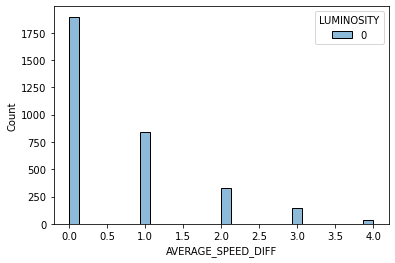

In [18]:
#Drop luminosity pode não ser importante
print(sns.histplot(data=df[df['LUMINOSITY']==0], hue = 'LUMINOSITY', x = 'AVERAGE_SPEED_DIFF'))

In [19]:
#Passar data para apenas a hora e passar a inteiro
df['record_date']=df['record_date'].str.slice(11,-6).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   record_date              6812 non-null   int64  
 1   AVERAGE_SPEED_DIFF       6812 non-null   int64  
 2   AVERAGE_FREE_FLOW_SPEED  6812 non-null   float64
 3   AVERAGE_TIME_DIFF        6812 non-null   float64
 4   AVERAGE_FREE_FLOW_TIME   6812 non-null   float64
 5   LUMINOSITY               6812 non-null   int64  
 6   AVERAGE_TEMPERATURE      6812 non-null   float64
 7   AVERAGE_ATMOSP_PRESSURE  6812 non-null   float64
 8   AVERAGE_HUMIDITY         6812 non-null   float64
 9   AVERAGE_WIND_SPEED       6812 non-null   float64
 10  AVERAGE_CLOUDINESS       6812 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 585.5 KB


In [20]:
df.describe()

,record_date,AVERAGE_SPEED_DIFF,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS
count,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000,6812.000000
mean,11.534498,1.442454,40.661010,25.637111,81.143952,1.005872,16.193482,1017.388139,80.084190,3.058573,2.449060
std,6.939520,1.275478,4.119023,33.510507,8.294401,0.980336,5.163492,5.751061,18.238863,2.138421,1.595367
min,0.000000,0.000000,30.500000,0.000000,46.400000,0.000000,0.000000,985.000000,14.000000,0.000000,0.000000
25%,6.000000,0.000000,37.600000,2.275000,75.400000,0.000000,13.000000,1015.000000,69.750000,1.000000,1.000000
50%,12.000000,1.000000,40.700000,12.200000,82.400000,1.000000,16.000000,1017.000000,83.000000,3.000000,2.000000
75%,18.000000,2.000000,43.500000,36.200000,87.400000,2.000000,19.000000,1021.000000,93.000000,4.000000,4.000000
max,23.000000,4.000000,55.900000,296.500000,112.000000,2.000000,35.000000,1033.000000,100.000000,14.000000,6.000000


In [21]:
df_prepared = df

### **Dados tratados. Vamos explorar relações entre features**

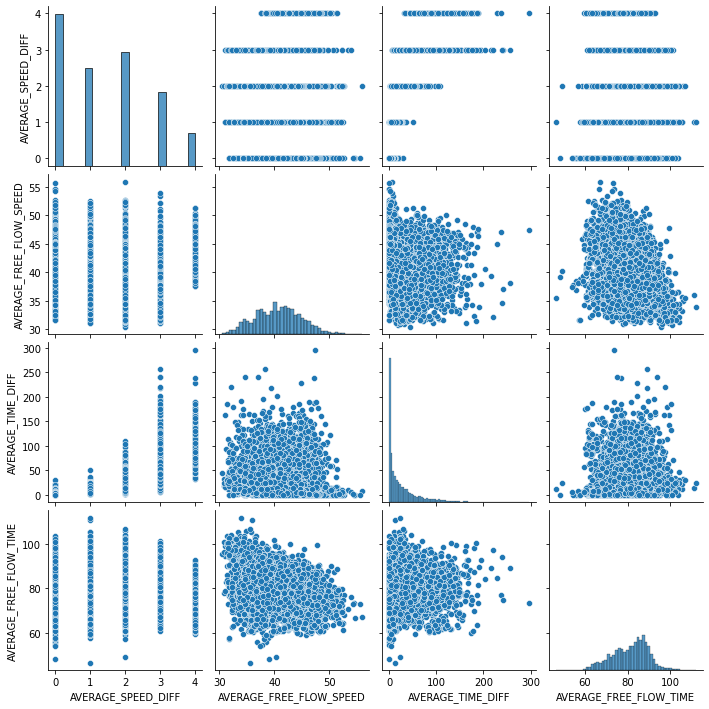

In [22]:
cols = ['AVERAGE_SPEED_DIFF','AVERAGE_FREE_FLOW_SPEED', 'AVERAGE_TIME_DIFF', 'AVERAGE_FREE_FLOW_TIME']

sns.pairplot(df_prepared[cols], height=2.5)

<AxesSubplot:xlabel='AVERAGE_TIME_DIFF'>

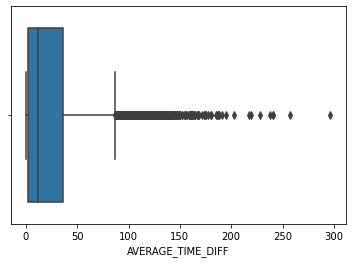

In [23]:
sns.boxplot(x=df_prepared['AVERAGE_TIME_DIFF'])

<AxesSubplot:xlabel='AVERAGE_TIME_DIFF', ylabel='Count'>

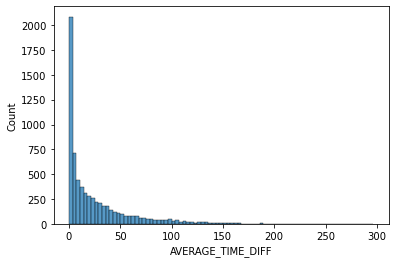

In [24]:
sns.histplot(data=df_prepared, x='AVERAGE_TIME_DIFF')

In [25]:
df_prepared['AVERAGE_TIME_DIFF'].describe()

count    6812.000000
mean       25.637111
std        33.510507
min         0.000000
25%         2.275000
50%        12.200000
75%        36.200000
max       296.500000
Name: AVERAGE_TIME_DIFF, dtype: float64

In [26]:
from scipy.stats.mstats import winsorize

time_dif = df_prepared['AVERAGE_TIME_DIFF']
time_dif.quantile(0.01)
time_dif.quantile(0.99)

143.38900000000004

In [27]:
time_dif_win = winsorize(time_dif, (0.01,0.01))
time_dif_win

masked_array(data=[11.5, 48.3, 38.4, ...,  0. ,  0. , 32.9],
             mask=False,
       fill_value=1e+20)

<AxesSubplot:>

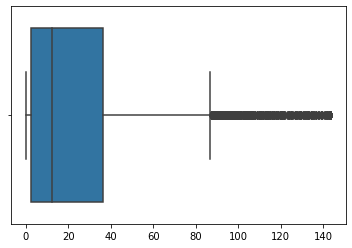

In [28]:
sns.boxplot(x=time_dif_win)

<AxesSubplot:xlabel='AVERAGE_TIME_DIFF'>

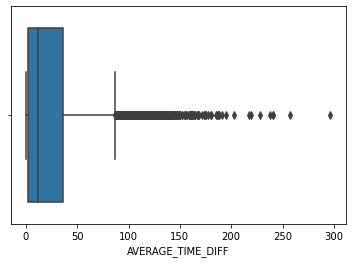

In [29]:
#df_prepared['AVERAGE_TIME_DIFF'] = time_dif_win
sns.boxplot(x = df_prepared['AVERAGE_TIME_DIFF'])

In [30]:
df_prepared.head()
df_prepared.describe()
print(df_prepared.isna().sum())

record_date                0
AVERAGE_SPEED_DIFF         0
AVERAGE_FREE_FLOW_SPEED    0
AVERAGE_TIME_DIFF          0
AVERAGE_FREE_FLOW_TIME     0
LUMINOSITY                 0
AVERAGE_TEMPERATURE        0
AVERAGE_ATMOSP_PRESSURE    0
AVERAGE_HUMIDITY           0
AVERAGE_WIND_SPEED         0
AVERAGE_CLOUDINESS         0
dtype: int64


## **Dados tratados. Fazer predictions**

In [31]:
x = df_prepared.drop(['AVERAGE_SPEED_DIFF'], axis=1)
y = df_prepared['AVERAGE_SPEED_DIFF'].to_frame()

In [32]:
# Split for test
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20, random_state=2000)

In [33]:
clf = DecisionTreeClassifier(random_state = 2021)
scores=cross_val_score(clf,x_train,y_train,cv=10)
print("RESULT: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(),scores.std()))

RESULT: 0.72 accuracy with a standard deviation of 0.02


<AxesSubplot:xlabel='AVERAGE_SPEED_DIFF', ylabel='count'>

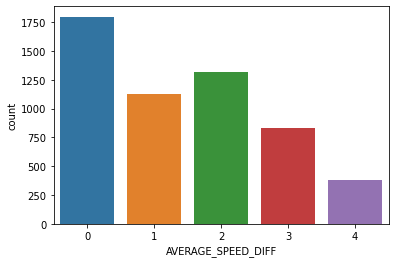

In [43]:
label = 'AVERAGE_SPEED_DIFF'
sns.countplot(x=label, data = y_train)

<AxesSubplot:xlabel='AVERAGE_SPEED_DIFF', ylabel='count'>

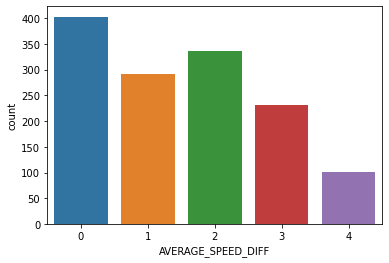

In [44]:
label = 'AVERAGE_SPEED_DIFF'
sns.countplot(x=label, data = y_test)

In [45]:
clf.fit(x_train,y_train)
predictions = clf.predict(x_test)
predictions

array([2, 0, 2, ..., 1, 0, 2])

In [46]:
print("%0.2f accuracy" % (accuracy_score(y_test,predictions)))

0.71 accuracy


In [49]:
criterion = ['gini', 'entropy']
max_depth = [2,3,4,6,8,10,12]

param_grid = {'criterion':criterion, 'max_depth':max_depth}
grid = GridSearchCV(DecisionTreeClassifier(random_state=2021),param_grid,refit=True,verbose=3)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END .......criterion=gini, max_depth=2;, score=0.616 total time=   0.0s
[CV 2/5] END .......criterion=gini, max_depth=2;, score=0.628 total time=   0.0s
[CV 3/5] END .......criterion=gini, max_depth=2;, score=0.619 total time=   0.0s
[CV 4/5] END .......criterion=gini, max_depth=2;, score=0.645 total time=   0.0s
[CV 5/5] END .......criterion=gini, max_depth=2;, score=0.626 total time=   0.0s
[CV 1/5] END .......criterion=gini, max_depth=3;, score=0.752 total time=   0.0s
[CV 2/5] END .......criterion=gini, max_depth=3;, score=0.742 total time=   0.0s
[CV 3/5] END .......criterion=gini, max_depth=3;, score=0.741 total time=   0.0s
[CV 4/5] END .......criterion=gini, max_depth=3;, score=0.764 total time=   0.0s
[CV 5/5] END .......criterion=gini, max_depth=3;, score=0.725 total time=   0.0s
[CV 1/5] END .......criterion=gini, max_depth=4;, score=0.751 total time=   0.0s
[CV 2/5] END .......criterion=gini, max_depth=4;

GridSearchCV(estimator=DecisionTreeClassifier(random_state=2021),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 6, 8, 10, 12]},
             verbose=3)

In [50]:
grid_predictions = grid.predict(x_test)
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       403
           1       0.66      0.74      0.70       292
           2       0.75      0.63      0.69       336
           3       0.69      0.74      0.71       231
           4       0.79      0.78      0.79       101

    accuracy                           0.76      1363
   macro avg       0.76      0.76      0.76      1363
weighted avg       0.77      0.76      0.76      1363



In [51]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 6}

In [52]:
grid_predictions

array([2, 0, 2, ..., 1, 0, 2])

## **Usar o modelo para prever as labels dos dados de teste**

In [53]:
df_training = tratamentoDados(training_file)
labelToNumeric(df_training)
df_test = tratamentoDados(test_file)

In [54]:
x = df_training.drop(['AVERAGE_SPEED_DIFF'], axis=1)
y = df_training['AVERAGE_SPEED_DIFF'].to_frame()

In [55]:
grid = GridSearchCV(DecisionTreeClassifier(random_state=2021),param_grid,refit=True,verbose=3)
grid.fit(x, y)
grid_predictions = grid.predict(df_test)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END .......criterion=gini, max_depth=2;, score=0.613 total time=   0.0s
[CV 2/5] END .......criterion=gini, max_depth=2;, score=0.610 total time=   0.0s
[CV 3/5] END .......criterion=gini, max_depth=2;, score=0.636 total time=   0.0s
[CV 4/5] END .......criterion=gini, max_depth=2;, score=0.614 total time=   0.0s
[CV 5/5] END .......criterion=gini, max_depth=2;, score=0.621 total time=   0.0s
[CV 1/5] END .......criterion=gini, max_depth=3;, score=0.733 total time=   0.0s
[CV 2/5] END .......criterion=gini, max_depth=3;, score=0.743 total time=   0.0s
[CV 3/5] END .......criterion=gini, max_depth=3;, score=0.759 total time=   0.0s
[CV 4/5] END .......criterion=gini, max_depth=3;, score=0.728 total time=   0.0s
[CV 5/5] END .......criterion=gini, max_depth=3;, score=0.741 total time=   0.0s
[CV 1/5] END .......criterion=gini, max_depth=4;, score=0.726 total time=   0.0s
[CV 2/5] END .......criterion=gini, max_depth=4;

In [56]:
grid_predictions

array([0, 1, 0, ..., 0, 4, 1])

In [81]:
indexes = list(range(1500))
try1 = pd.DataFrame(data=grid_predictions, index=None, columns=['Speed_Diff'])
try1

,Speed_Diff
0,0
1,1
2,0
3,3
4,1
...,...
1495,1
1496,1
1497,0
1498,4


In [89]:
try1['RowId'] = range(1,1501)
try1['Speed_Diff'].replace({0:"None", 1:"Low", 2:"Medium", 3:"High", 4:"Very_High"}, inplace=True)
try1 = try1[['RowId','Speed_Diff']]
try1

,RowId,Speed_Diff
0,1,None
1,2,Low
2,3,None
3,4,High
4,5,Low
...,...,...
1495,1496,Low
1496,1497,Low
1497,1498,None
1498,1499,Very_High


In [90]:
try1.to_csv('mane_try1.csv',index=False)
submission = pd.read_csv('mane_try1.csv',encoding = "ISO-8859-1")
submission.head()

,RowId,Speed_Diff
0,1,None
1,2,Low
2,3,None
3,4,High
4,5,Low
